# Problem with metacal function stacking

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import autometacal

In [3]:
##Local settings
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import galsim
import tensorflow as tf
import tqdm

## Create some data

In [4]:
seed = 31415
rng = np.random.RandomState(seed)

In [5]:
def make_data(N=1,
  psf_noise = 1.0e-5,
  img_noise = 1.0e-4,
  scale = 0.263,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0]):
  
  gal_list = []
  psf_list = []
  
  for n in range(N):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array

    psf_image += rng.normal(scale=psf_noise, size=psf_image.shape)
    gal_image += rng.normal(scale=img_noise, size=gal_image.shape)
    gal_image = tf.convert_to_tensor(gal_image)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
    del gal_image
    del psf_image
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [37]:
img_noise = 1.0e-5
psf_noise = img_noise/10
scale = 0.263
stamp_size = 64
psf_fwhm = 0.9
gal_hlr = 0.5

gal_images, psf_images = make_data(N=2,psf_noise = psf_noise,
                                  img_noise = img_noise,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1 = [0.0,.0,0.0],gal_g2=[0.0,.0,.0])

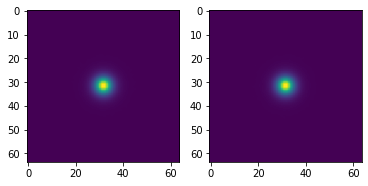

In [38]:
subplot(121)
imshow(gal_images[0])
subplot(122)
imshow(gal_images[1])

## Create Reconvolution PSF

In [39]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)

## Create "zero test": difference between the same ops to check deterministic execution

In [44]:
gal_image = gal_images[0:2]
psf_image = psf_images[0:2]
img0s1 = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,0]])
gal_image = gal_images[0:2]
psf_image = psf_images[0:2]
img0s2 = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,0]])

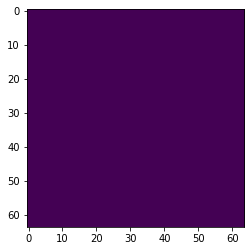

In [45]:
imshow(img0s1[0]-img0s2[0])

## Confront results for 1st galaxy of a 2 galaxy and 1 galaxy set.

In [46]:
gal_image = gal_images[0:2]
psf_image = psf_images[0:2]
img0s1 = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,0]])
gal_image = gal_images[0:1]
psf_image = psf_images[0:1]
img0s2 = autometacal.generate_mcal_image(gal_image,psf_image,reconv_psf_image,[[0,0]])

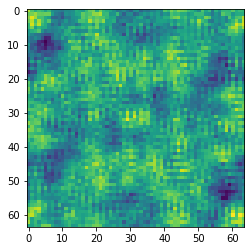

In [47]:
imshow(img0s1[0]-img0s2[0])

# !!!